# Session 02 - Convolutional Neural Networks - Assignment

## Goal

Convolutional Neural Networks are unmatched when it comes to image recognition tasks.
In this assignment, you'll apply them to both image recognition and object detection. It will involve designing you own custom CNN, but also applying transfer learning where you'll start from a pre-trained CNN and re-train it to your own classification task. 


In [1]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlp


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage
import seaborn as sns
#import Tensorflow namespaces

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions

import pickle

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [14]:
mlp.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [12]:
def evaluate_model_multiclass(history, X_test, y_test):
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    for n, metric in enumerate(metrics):
      name = metric.replace("_"," ").capitalize()
      plt.subplot(2,2,n+1)
      plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
      plt.plot(history.epoch, history.history['val_'+metric],
              color=colors[1], linestyle="--", label='Val')
      plt.xlabel('Epoch')
      plt.ylabel(name)
      
    plt.legend()

    y_predicted = np.argmax(history.model.predict(X_test),axis=-1)

    print(classification_report(y_test, y_predicted))

    cf = confusion_matrix(y_test, y_predicted)

    print(cf)
    print(accuracy_score(y_test, y_predicted) * 100) 

# Fashion MNIST with CNN

The Fashion-MNIST dataset consists of thousands of grey-valued images of clothes from 10 different classes: 0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'.

The training set and test set are provided.

- Train and optimze a CNN achieving the highest possible accuracy on the test set. 

Write down some conclusions:
- What is the achieved accuracy? How about the recall-values of the different classes?
- Is there an imbalance between the performance on the different classes? Does the neural network have a preference for a certain class?
- Visualize a couple of misclassified images. For examples the top 10 images with the highest loss. 
- Check if you neural network is suffering from overfitting and how you have applied regularization.


### Inlezen & splitten van de dataset

In [4]:
# Inlezen fashion MNIST dataset

df_train = pd.read_csv('./fashion-mnist_train.csv')
df_test = pd.read_csv('./fashion-mnist_test.csv')
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Split into features and targets

train_labels = df_train.label.values
test_labels = df_test.label.values

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

X_train = df_train.drop('label',axis=1).values
X_test  = df_test.drop('label',axis=1).values

print(X_train.shape)
print(X_test.shape)

X_train = X_train.reshape((len(X_train),1,28,28)).transpose(0,3,2,1)
X_test  = X_test.reshape((len(X_test),1,28,28)).transpose(0,3,2,1)


print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


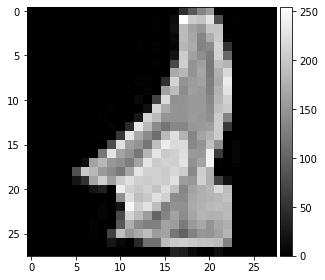

In [48]:
imshow(X_train[1], cmap='gray')

In [8]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

### Model Creation & Run

In [70]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [66]:
adam = tf.keras.optimizers.Adam(lr = 0.0003)

# Neural network parameters
#-----------------------------------------------
#-----------------------------------------------
batch_size = 32 # 
epochs = 50 # 
#-----------------------------------------------
#-----------------------------------------------
num_classes = y_train.shape[1]
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols,1)


# Model
model = Sequential()
#-----------------------------------------------
#-----------------------------------------------
model.add(Conv2D(16, kernel_size=(4, 4), input_shape=input_shape)) 
#-----------------------------------------------
model.add(BatchNormalization())
#-----------------------------------------------
model.add(Activation('relu'))
#-----------------------------------------------
model.add(MaxPooling2D(pool_size=(2, 2)))
#-----------------------------------------------
model.add(Conv2D(16, kernel_size=(3, 3))) 
#-----------------------------------------------
model.add(BatchNormalization())
#-----------------------------------------------
model.add(Activation('relu'))
#-----------------------------------------------         
model.add(MaxPooling2D(pool_size=(2, 2)))
#-----------------------------------------------
#-----------------------------------------------
#-----------------------------------------------
model.add(Flatten()) 
model.add(Dropout(0.4)) # Value between 0 and 1 
model.add(Dense(20, activation='relu')) 
#-----------------------------------------------
#-----------------------------------------------
model.add(Dropout(0.4)) # Value between 0 and 1 
#-----------------------------------------------
#-----------------------------------------------
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=METRICS)

# Trainen van het CNN
history = model.fit(X_train, y_train,batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

C:\Users\Jakob\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50
1500/1500 [==============================] - 25s 15ms/step - loss: 1.4670 - tp: 13845.0000 - fp: 3645.0000 - tn: 428355.0000 - fn: 34155.0000 - accuracy: 0.9213 - precision: 0.7916 - recall: 0.2884 - auc: 0.8687 - prc: 0.5518 - val_loss: 0.6873 - val_tp: 6800.0000 - val_fp: 554.0000 - val_tn: 107446.0000 - val_fn: 5200.0000 - val_accuracy: 0.9520 - val_precision: 0.9247 - val_recall: 0.5667 - val_auc: 0.9779 - val_prc: 0.8701
Epoch 2/50
1500/1500 [==============================] - 23s 15ms/step - loss: 0.9190 - tp: 24985.0000 - fp: 5041.0000 - tn: 426959.0000 - fn: 23015.0000 - accuracy: 0.9416 - precision: 0.8321 - recall: 0.5205 - auc: 0.9521 - prc: 0.7648 - val_loss: 0.5421 - val_tp: 8394.0000 - val_fp: 900.0000 - val_tn: 107100.0000 - val_fn: 3606.0000 - val_accuracy: 0.9625 - val_precision: 0.9032 - val_recall: 0.6995 - val_auc: 0.9844 - val_prc: 0.9014
Epoch 3/50
1500/1500 [==============================] - 23s 16ms/step - loss: 0.7833 - tp: 28262.0000 - fp: 5170.0000 

### Resultaat

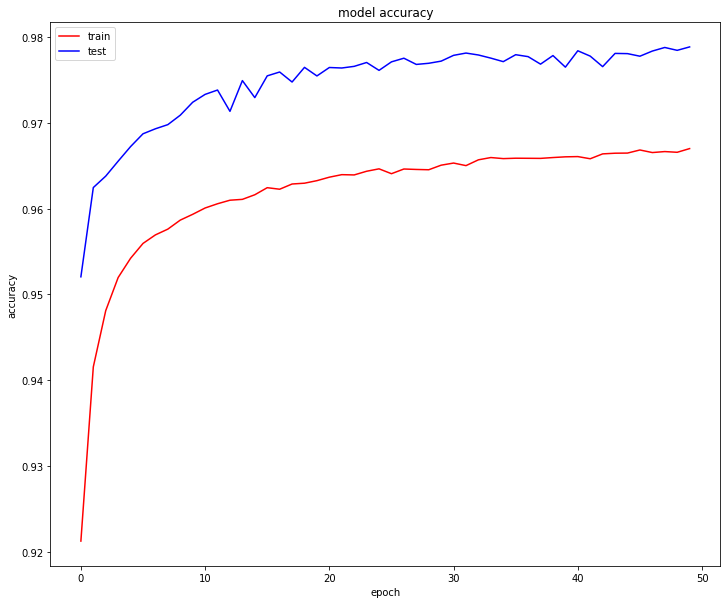

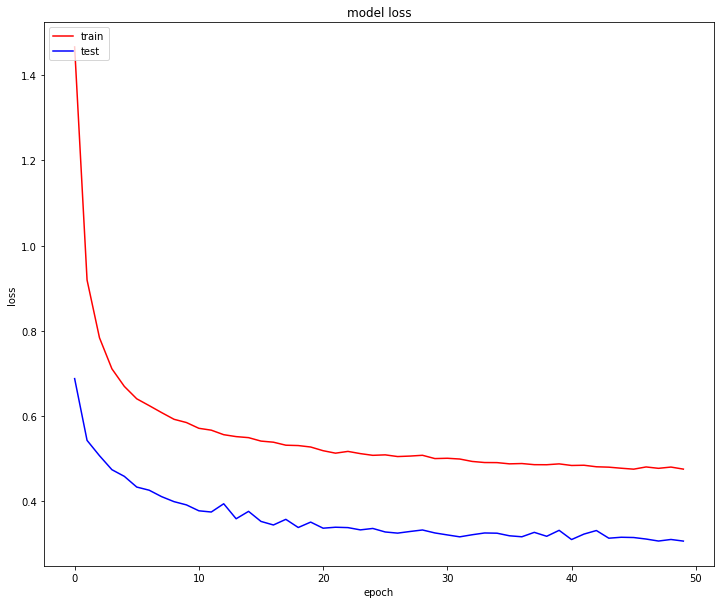

In [68]:
# Plot history

# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

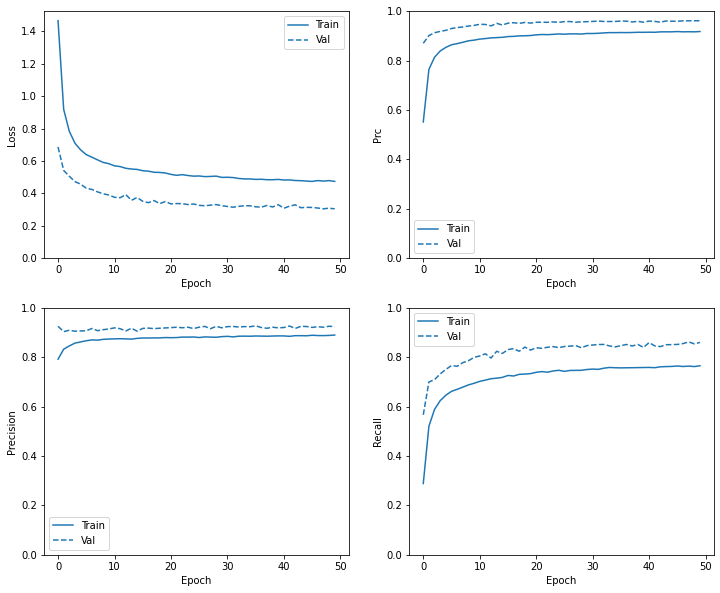

In [69]:
plot_metrics(history)

In [70]:
# Confusion matrix
y_predicted = np.argmax(model.predict(X_test),axis=-1)

print(classification_report(test_labels, y_predicted))

cf = confusion_matrix(test_labels, y_predicted)

print(cf)
print(accuracy_score(test_labels, y_predicted) * 100) 

              precision    recall  f1-score   support

           0       0.79      0.86      0.83      1000
           1       0.99      0.98      0.99      1000
           2       0.87      0.83      0.85      1000
           3       0.87      0.93      0.90      1000
           4       0.81      0.87      0.84      1000
           5       0.98      0.96      0.97      1000
           6       0.72      0.61      0.66      1000
           7       0.94      0.95      0.95      1000
           8       0.98      0.98      0.98      1000
           9       0.95      0.97      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

[[859   0  11  35   2   1  84   1   7   0]
 [  0 983   1  12   1   0   3   0   0   0]
 [ 14   0 833  12  77   0  63   0   1   0]
 [ 17   6   6 929  20   0  20   0   1   1]
 [  0   0  33  41 869   0  56   0   1   0]
 [  0   1   0   0   0 958 

### Visualisatie misclassified images

1062 of 10000 items wrongly classified


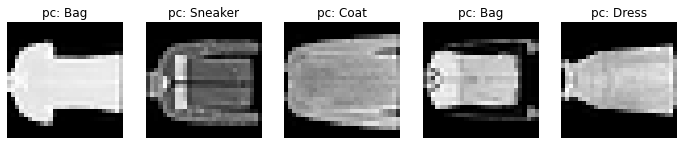

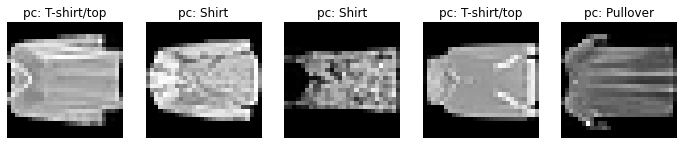

In [94]:
y_pred = model.predict(X_test).argmax(axis=-1)

misclassified = X_test[np.not_equal(y_pred, test_labels)]


print(f"{misclassified.shape[0]} of {y_test.shape[0]} items wrongly classified")

legende = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag','Ankle boot']
for i in range(2):
    plt.figure()
    for i in range(5):
        
        rand = int(np.random.rand() * misclassified.shape[0])
        plt.subplot(151+i)
        plt.imshow(misclassified[rand], cmap="gray")
        # plt.xlabel(f"predicted class: {y_pred[rand]}")
        
        plt.axis("off")
        plt.title(f"pc: {legende[y_pred[rand]]}")
        
    plt.show()   

### Conclusion

1. What is the achieved accuracy? How about the recall-values of the different classes?
2. Is there an imbalance between the performance on the different classes? Does the neural network have a preference for a certain class?
3. Visualize a couple of misclassified images. For examples the top 10 images with the highest loss. 
4. Check if you neural network is suffering from overfitting and how you have applied regularization.

0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'.

1. 89.3%, This is already higher then w/o a Convolutional NN. Recall & Precision are all around quite good, just class 6: shirt does not perform that well. Class 1 is a bit lower aswell but this is due to the confusion between class 1 & 6

2. Part I:
    - Class 6: shirt, has the worst accuracy, precision & recall. This could be because the shape of the image is very similar to other classes such as coat, pullover and t-shirt. 
    - The NN does not seem to have a preference for a certain class. This is logical as the dataset is perfectly balanced and we didnt give any class_weights.

4. See above

5. The NN does not seem to be overfitting, it's actually performing quite good on our test set. 

# 2. Car Detection

The goal is to build a working car detector capable of finding the location of a car/cars in traffic images. 
Once the location is determined, a bounding box is drawn around the detected car. See the example below:


![alt text](./JupyterImages/cardetectionExample.png "Title")

You can split the implementation into two main parts:

1. Train a CNN as a binary classifier that can distinguish cars from non-cars.
2. Now use the trained classifier to discover cars in a complex image.

### Step 1. Car classifier

The folder "vehicles" contains thousands of car images. The folder "non-vehicles", contains thousands of images of other objects. 

- Train and optimize a CNN on these images so it can accurately discriminate cars from non-cars. You have the freedom to decide on architecture of the neural network, the hyperparameters, the size of the training set and test set, etc.

- Train a VGG19 network and compare the performance to your own custom CNN. 




**Attention!**

- Due to the large number of images, you might run out of memory (and computational resources). Therefore it's recommended to only use a subset of the entire dataset. Later you can always use a bigger dataset if you systems rersources allow this.

- Scale the images to float values raning between 0 and 1:

```Python
X_car = X_car.astype('float32')`
X_car /= 255```





In [2]:
import glob, random
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Load all images from the "vehicles" and "non-vehicles" folder
max_images = 20000

def load_images(path):

    images = []
    for image_file in os.listdir(path):

        image = io.imread(os.path.join(path, image_file))
        if image is not None:
            images.append(image)
            

    return images

vehicles = load_images('./vehicles')
non_vehicles = load_images('./non-vehicles')


In [4]:
# Normalization of values
Xs = vehicles + non_vehicles
Xs = np.array(Xs)

Xs = Xs.astype('float32')
Xs /= 255


In [5]:

print(class_labels)

[1 1 1 ... 0 0 0]


In [6]:
# Devide the Xs into training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xs, class_labels, test_size=0.2, random_state=20)

y_train = to_categorical(y_train)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14208, 64, 64, 3)
(3552, 64, 64, 3)
(14208, 2)
(3552,)


### Normal CNN

In [7]:
METRICS = [ 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [9]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)

# Neural network parameters
#-----------------------------------------------
#-----------------------------------------------
batch_size = 64 #
epochs = 50 # 

kernel_size=(3,3)
#-----------------------------------------------
#-----------------------------------------------
num_classes = 2
input_shape = (64, 64, 3)

# Model
model = Sequential()
model.add(Conv2D(16, kernel_size=kernel_size, input_shape=input_shape)) 
model.add(BatchNormalization())

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=kernel_size)) 

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten()) 
model.add(Dropout(0.4)) 
model.add(Dense(20, activation='relu')) 

model.add(Dropout(0.4))

model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.001, patience=10, restore_best_weights=True)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=METRICS)

# model.summary()




In [10]:
# Trainen van het CNN

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

# history = model.fit(X_train, y_train,batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1, callbacks = [es])


Epoch 1/50
178/178 [==============================] - 19s 52ms/step - loss: 0.5303 - accuracy: 0.7409 - precision: 0.7409 - recall: 0.7409 - auc: 0.8189 - prc: 0.8148 - val_loss: 0.7921 - val_accuracy: 0.5070 - val_precision: 0.5070 - val_recall: 0.5070 - val_auc: 0.6727 - val_prc: 0.70939 - precision: 0.7149 - recall: 0.71
Epoch 2/50
178/178 [==============================] - 20s 114ms/step - loss: 0.3176 - accuracy: 0.8657 - precision: 0.8657 - recall: 0.8657 - auc: 0.9388 - prc: 0.9391 - val_loss: 0.4762 - val_accuracy: 0.7526 - val_precision: 0.7526 - val_recall: 0.7526 - val_auc: 0.8529 - val_prc: 0.8614y: 0.8434 - precision: 0.8434 - recall - ETA: 3s - loss: 0.3450 - accuracy: 0.8530 - p
Epoch 3/50
178/178 [==============================] - 10s 59ms/step - loss: 0.2254 - accuracy: 0.9098 - precision: 0.9098 - recall: 0.9098 - auc: 0.9694 - prc: 0.9694 - val_loss: 0.2360 - val_accuracy: 0.8895 - val_precision: 0.8895 - val_recall: 0.8895 - val_auc: 0.9661 - val_prc: 0.9675ecall: 0

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1800
           1       0.99      1.00      0.99      1752

    accuracy                           0.99      3552
   macro avg       0.99      0.99      0.99      3552
weighted avg       0.99      0.99      0.99      3552

[[1781   19]
 [   5 1747]]
99.32432432432432


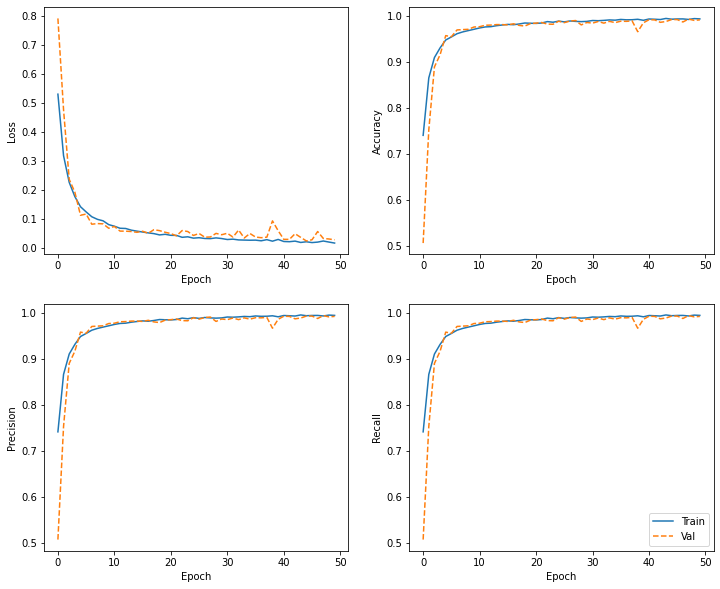

In [15]:
evaluate_model_multiclass(history, X_test, y_test)

In [16]:
# Save model
model.save('./model/car_classifier.h5')

In [17]:
from tensorflow.keras.models import load_model
# Load model
model = load_model('./model/car_classifier.h5')

In [18]:
y_predicted = np.argmax(model.predict(X_test),axis=-1)

print(classification_report(y_test, y_predicted))

cf = confusion_matrix(y_test, y_predicted)

print(cf)
print(accuracy_score(y_test, y_predicted) * 100) 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1800
           1       0.99      1.00      0.99      1752

    accuracy                           0.99      3552
   macro avg       0.99      0.99      0.99      3552
weighted avg       0.99      0.99      0.99      3552

[[1781   19]
 [   5 1747]]
99.32432432432432


### VGG19 Classifier

In [19]:
METRICS = [ 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [20]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.00001)

# VGG19 classifier
from tensorflow.keras.applications.vgg19 import VGG19
model_vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(64,64,3))

# Convert to Keras model
model = Sequential()

for layer in model_vgg19.layers[:]:
    model.add(layer)

# set coefficients to fixed
for layer in model.layers:
    layer.trainable = False

# Add custom dense layers

model.add(Flatten()) 
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(2,activation='softmax'))


model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=METRICS)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 16, 16, 256)      

In [21]:
# Train VGG model
batch_size = 64
epochs = 50
history = model.fit(X_train, y_train, batch_size=batch_size, shuffle= True, validation_split =0.2, epochs=epochs, verbose=1)

Epoch 1/50
178/178 [==============================] - 69s 341ms/step - loss: 0.4768 - accuracy: 0.7785 - precision: 0.7785 - recall: 0.7785 - auc: 0.8567 - prc: 0.8522 - val_loss: 0.3372 - val_accuracy: 0.9029 - val_precision: 0.9029 - val_recall: 0.9029 - val_auc: 0.9671 - val_prc: 0.9673
Epoch 2/50
178/178 [==============================] - 49s 276ms/step - loss: 0.2226 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9805 - prc: 0.9808 - val_loss: 0.1855 - val_accuracy: 0.9441 - val_precision: 0.9441 - val_recall: 0.9441 - val_auc: 0.9888 - val_prc: 0.9890
Epoch 3/50
178/178 [==============================] - 29s 164ms/step - loss: 0.1587 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9904 - prc: 0.9907 - val_loss: 0.1357 - val_accuracy: 0.9578 - val_precision: 0.9578 - val_recall: 0.9578 - val_auc: 0.9932 - val_prc: 0.9933
Epoch 4/50
178/178 [==============================] - 15s 84ms/step - loss: 0.1308 - accuracy: 0.9597 - precision: 0.9597 - rec

In [22]:
model.save('./model/vgg_car_classifier.h5')

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       961
           1       1.00      0.93      0.96      2430

    accuracy                           0.95      3391
   macro avg       0.93      0.96      0.94      3391
weighted avg       0.96      0.95      0.95      3391

[[ 958    3]
 [ 164 2266]]
95.07519905632556


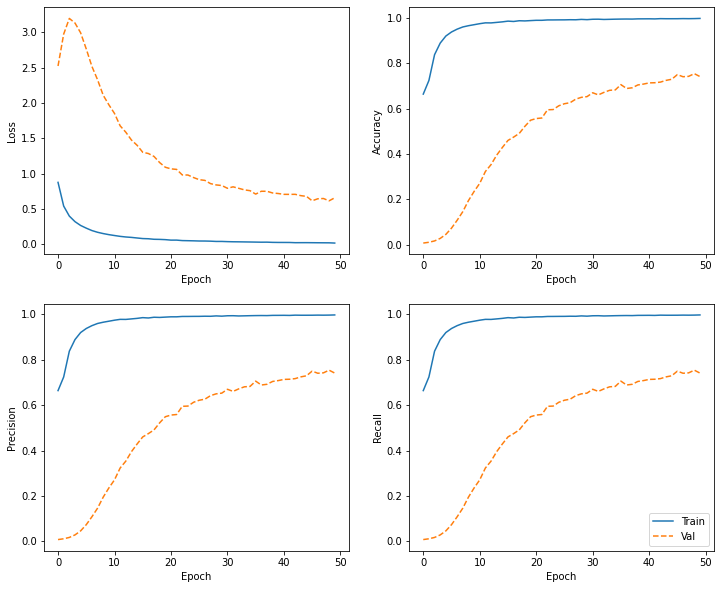

In [51]:
evaluate_model_multiclass(history, X_test, y_test)

### Step 2.  Sliding window detection

Now your CNN has been trained, you can employ it to detect cars in complex road traffic images. 
In practise you can reside to many different techniques, going from simple (but computationally slow) to sophisticated techniques (like YOLO).
In this assignment we'll use the sliding window technique. It means that in a systematic way you classify locally extracted regions of interest.
Concretely, scan the images in multiple passes from top left to the bottom right with a window (varying in size). Send the image through the car classifier (custom CNN or VGG19) to determine whether of not the sub-images contains a car. Draw a bounding box in case a car is detected.

The folder "StreetImages" contains some test images, but feel free to use you own ones.

To draw a bounding box, the following piece of Python code can be used:


```python
def rectangle_perimeter(r0, c0, width, height, shape=None, clip=False):
    rr, cc = [r0, r0 + width, r0 + width, r0], [c0, c0, c0 + height, c0 + height]
    return skimage.draw.polygon_perimeter(rr, cc, shape=shape, clip=clip)

# Drawing the bounding box:
rr, cc = rectangle_perimeter(y, x, w, w)
image_detected[rr,cc] =255

```
A car might be surrounded by multiple bounding boxes. Find a way to merge multiple bounding boxes into one bounding box.


In [4]:
from tensorflow.keras.models import load_model
# Load model
model = load_model('./model/car_classifier.h5')

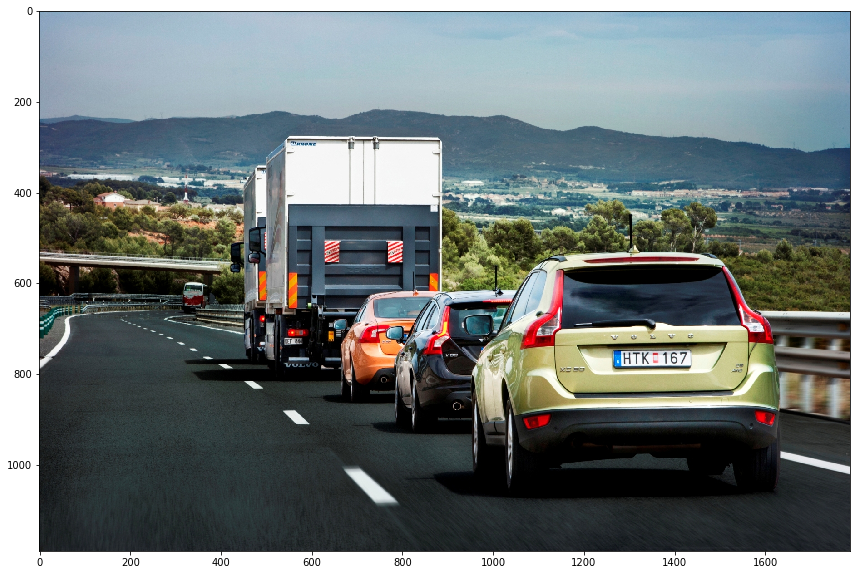

In [24]:
import random

def load_images(path):
    images = []
    for image_file in os.listdir(path):
        image = io.imread(os.path.join(path, image_file))
        if image is not None:
            images.append(image)
    return images

street_images = load_images('./StreetImages')

# Get a random image
image = street_images[3]

imshow(image)

In [37]:
from tensorflow.keras.models import load_model
# Load model
model = load_model('./model/car_classifier.h5')

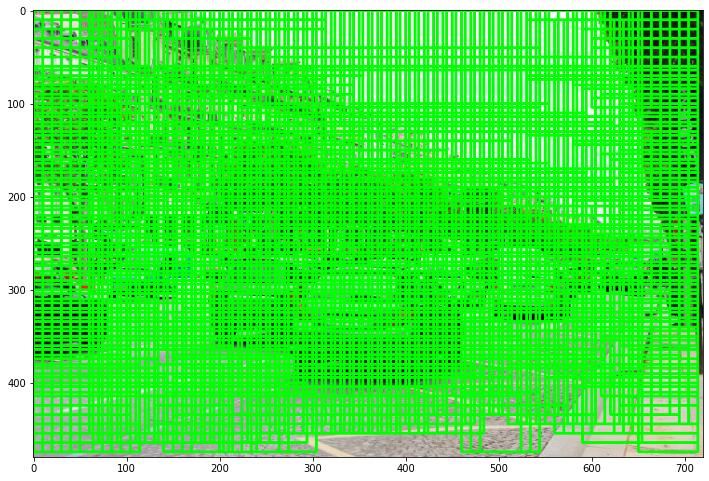

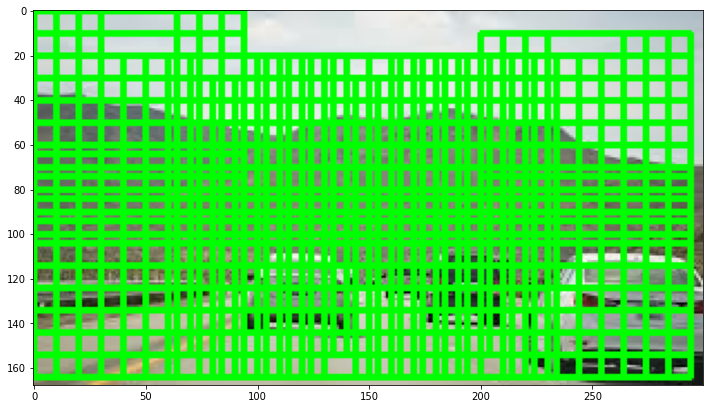

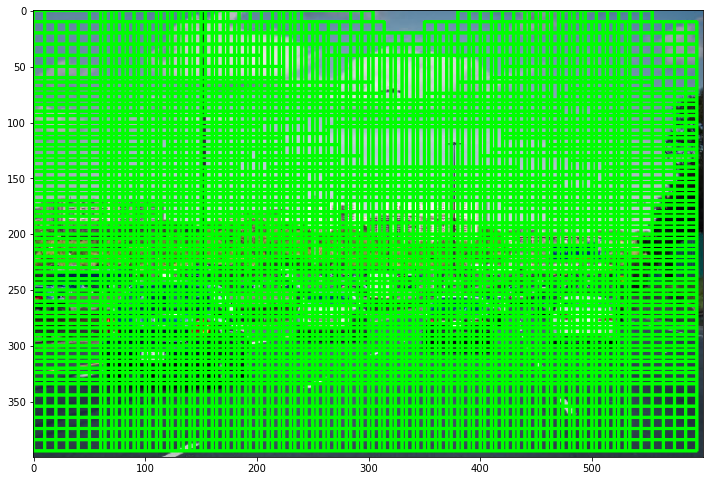

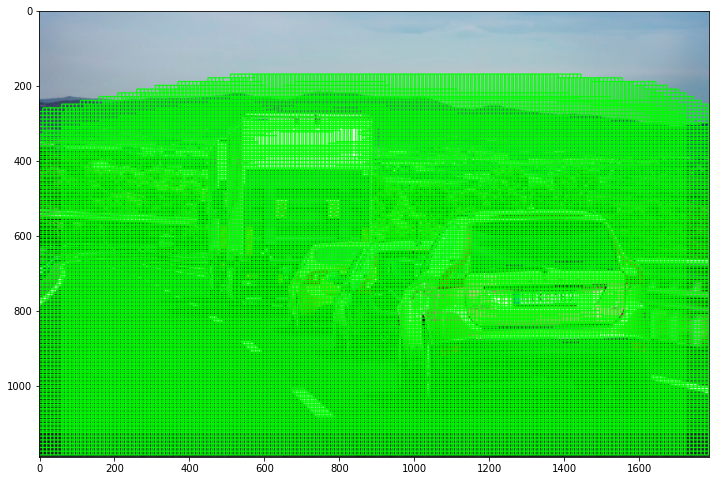

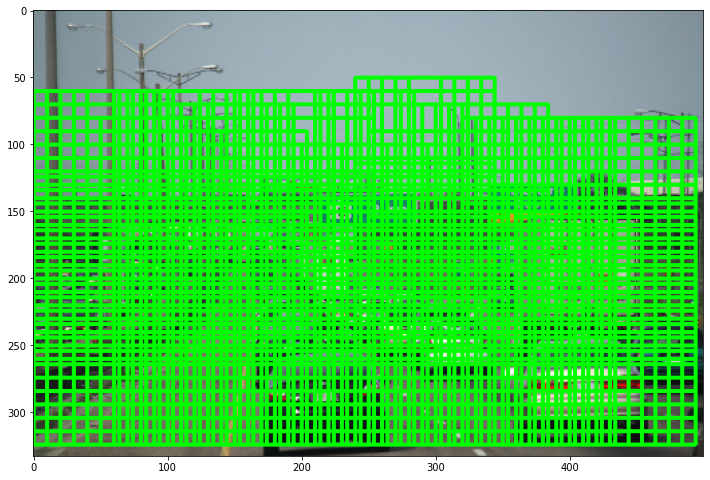

In [40]:
import cv2
# Sliding window detection on image with model and input size of 64x64
def sliding_window(image, model, input_shape, window_size = (64, 64)):
    # Define the window size
    
    windows = []
    
    # Iterate over the image
    for y in range(0, image.shape[0] - window_size[1], 10):
        for x in range(0, image.shape[1] - window_size[0], 10):
            # Crop the image
            crop = image[y:y + window_size[1], x:x + window_size[0]]
            # Resize the image
            crop = cv2.resize(crop, input_shape).astype('float32')
            # Normalize the image
            crop /= 255
            # Predict the class
            prediction = model.predict(np.array([crop]))
            # Draw a rectangle around the prediction
            if prediction[0][1] > 0.7:
                windows.append(1)
                cv2.rectangle(image, (x, y), (x + window_size[0], y + window_size[1]), (0, 255, 0), 2)
            else:
                windows.append(0)
    # Show the image
    plt.figure()
    plt.imshow(image)
    return windows

for image in street_images:
    windows = sliding_window(image, model, (64,64))

## Conclusion

#### As far as model creation goes everything went alright. It's very important to load in your data properly I did this poorly at first so the model was very volatile. 

### Custom CNN

This is the best model I could come up with, it's almost perfect aside from when training the model we can see that the validation set is not that accurate. When predicting on the test set however we come up with a pretty good result.


### VGG19 

I first tried to predict with the model on our test set. This actually came out a little bit decent. It predicted that it was a car multiple times (never the right car though). 

Then I trained the model myself. It has a decent result (could be configured better to get a more accurate result), but it seems to be worse than my custom made CNN. Again it did fine on our training & test set, but the validation set is very volatile again. 


### Sliding window

This is very hard to get it to work properly. It seems I have some issues with loading in the data or something because my model almost always predicts 'car'. So the image is just filled with rectangles. (I've commented the code below this is the code I used to use to load in the images, in essence I'm doing the same as now, but now I create a training/test set using train_test_split. This makes the data more streamlined between the 2 classes.)

I changed the way I load in the data and create the model. This seems to work a bit better. Still not very good, but the model generally gets where the cars are at. (sort of...) 


In [ ]:
# images = glob.glob("./all_images/*.png")

# rows, cols = imread(images[0]).shape[0], imread(images[0]).shape[1]

# training_images = [] # empty list
# test_images = [] # empty list
# y_train = [] # empty list
# y_test = [] # empty list

# sample_size = 20000

# for i in images: 
#     if len(training_images) + len(test_images) < sample_size:
#         if float(round(random.random(),2)) >= float(0.20):
#             if 'extra' in i:
#                 y_train.append(0)
#                 training_images.append(imread(i))
#             else: 
#                 y_train.append(1)
#                 training_images.append(imread(i))
#         else: 
#             if 'extra' in i:
#                 y_test.append(0)
#                 test_images.append(imread(i))
#             else: 
#                 y_test.append(1)
#                 test_images.append(imread(i))

 
# print("aantal training images: ", len(training_images))
# print("aantal test images: ", len(test_images))

# print("aantal images in training images: ", Counter(y_train))
# print("aantal images in test images: ", Counter(y_test))


# # Class_weight balancing
# train = Counter(y_train)
# test = Counter(y_test)

# pos = train[1] + test[1]
# neg = train[0] + test[0]
# total = len(images)

# # Scaling by total/2 helps keep the loss to a similar magnitude.
# # The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / neg) * (total / 2.0)
# weight_for_1 = (1 / pos) * (total / 2.0)dd

# class_weight = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

# training_images = np.asarray(training_images)
# test_images = np.asarray(test_images)

# X_train = training_images.reshape((len(training_images),64,64,3))
# X_test = test_images.reshape((len(test_images),64,64,3))

# y_train = np.asarray(y_train)
# y_test = np.asarray(y_test)

# # X_train = X_train.astype('float32')
# # X_test = X_test.astype('float32')
# # X_train /= 255
# # X_test /= 255

# y_train = to_categorical(y_train)

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)